# Stress Detection

### Importe de liberias

In [1]:
import pandas as pd
import numpy  as np
import re
import string
import plotly
import matplotlib.pyplot as plt
import time
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter


In [2]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score


In [3]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.model_selection import HalvingRandomSearchCV
import xgboost as xgb 

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt

### Lectura del dataset

In [5]:
df = pd.read_csv('https://raw.githubusercontent.com//valemicolgarcia//NLP-Natural-Language-Processing//main//Stress//Stress.csv')
df.head()

,subreddit,post_id,sentence_range,text,label,confidence,social_timestamp
0,ptsd,8601tu,"(15, 20)","He said he had not felt that way before, sugge...",1,0.8,1521614353
1,assistance,8lbrx9,"(0, 5)","Hey there r/assistance, Not sure if this is th...",0,1.0,1527009817
2,ptsd,9ch1zh,"(15, 20)",My mom then hit me with the newspaper and it s...,1,0.8,1535935605
3,relationships,7rorpp,"[5, 10]","until i met my new boyfriend, he is amazing, h...",1,0.6,1516429555
4,survivorsofabuse,9p2gbc,"[0, 5]",October is Domestic Violence Awareness Month a...,1,0.8,1539809005


In [6]:
df.shape

(2838, 7)

### Columnas del dataset

- subreddit: comunidad o foro especifico
- post_id : identificador del post
- sentence_range: indice de oraciones
- text: texto usado para detectar estres
- label: 0 significa "sin estres" , 1 significa "estres"
- confidence: nivel de confianza de la persona en el texto
- social_timestamp: marca de tiempo que registra el post


### Distribución del numero de palabras

Text(0, 0.5, 'Frecuencia')

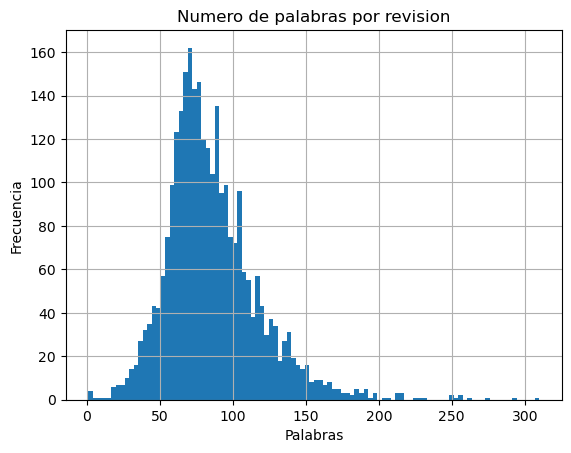

In [7]:
words_per_text = df['text'].apply(lambda x: len(x.split(" ")))
words_per_text.hist(bins = 100)
plt.title('Numero de palabras por revision')
plt.xlabel('Palabras')
plt.ylabel('Frecuencia')

In [8]:
words_per_text.mean()

85.84425651867512

### Distribución de los strings

In [9]:
df['label'].value_counts()

1    1488
0    1350
Name: label, dtype: int64

In [10]:
percent_val = 100 * df['label'].value_counts()/df.shape[0]
percent_val

1    52.43129
0    47.56871
Name: label, dtype: float64

Se observa que la distribucion de la variable a predecir es bastante pareja

Text(0, 0.5, 'Porcentaje (%)')

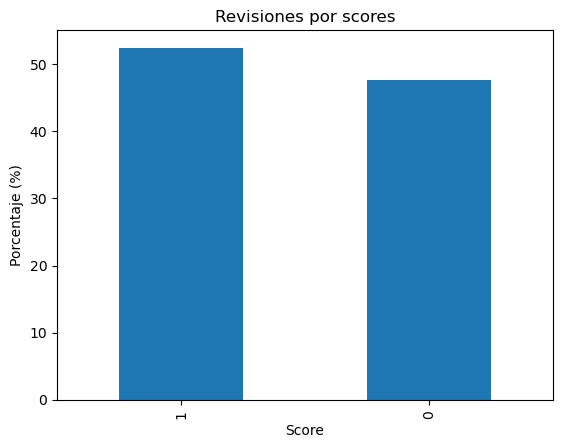

In [11]:
percent_val.plot.bar()
plt.title('Revisiones por scores')
plt.xlabel('Score')
plt.ylabel('Porcentaje (%)')

# WordCloud general del dataset

1271414


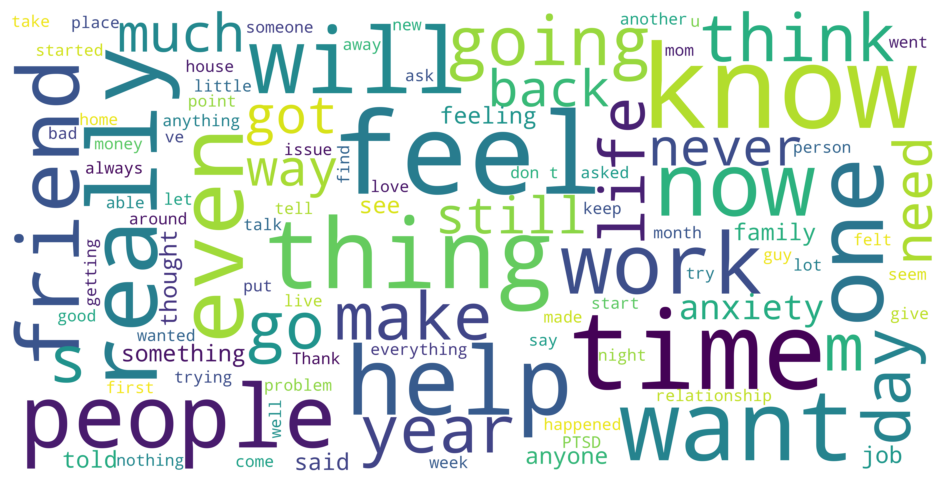

In [12]:
word_cloud_text = ''.join(df['text'])
print(len(word_cloud_text))

wordcloud = WordCloud(
    max_font_size=100,
    max_words=100,
    background_color="white",
    scale=10,
    width=800,
    height=400
).generate(word_cloud_text)

plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# WordCloud para personas estresadas

Length of text for target = 1: 685515


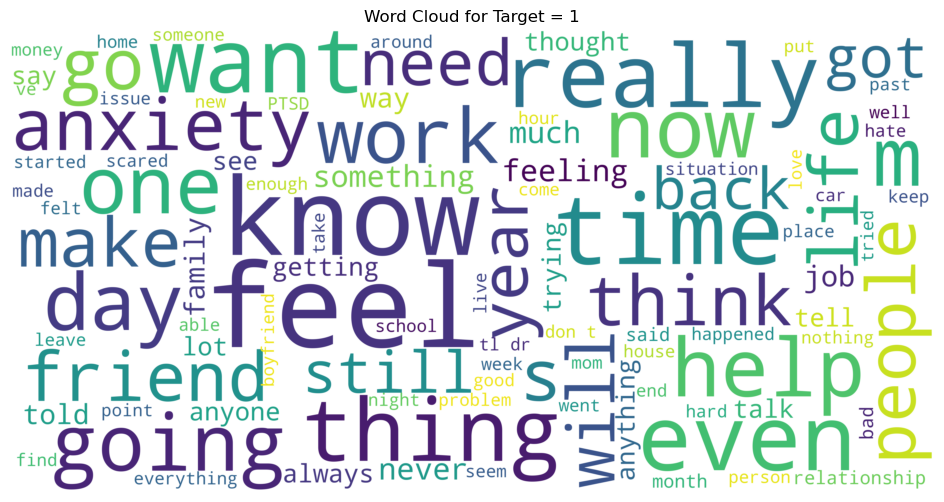

In [13]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Filtrar el DataFrame en función del valor de 'target'
text_target_1 = ' '.join(df[df['label'] == 1]['text'])

# Verificar longitud del texto para target = 1
print(f"Length of text for target = 1: {len(text_target_1)}")

# Crear la nube de palabras para target = 1
wordcloud_1 = WordCloud(
    max_font_size=100,
    max_words=100,
    background_color="white",
    scale=10,
    width=800,
    height=400
).generate(text_target_1)

# Configurar y mostrar la nube de palabras
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud_1, interpolation="bilinear")
plt.axis("off")
plt.title('Word Cloud for Target = 1')
plt.show()


Podemos ver que en las personas que se encuentran estresadas, las palabras mas comunes son "anxiety" , "friend", "work", "need", "back", "time", "know"

# WordCloud para personas no estresadas

Length of text for target = 0: 685515


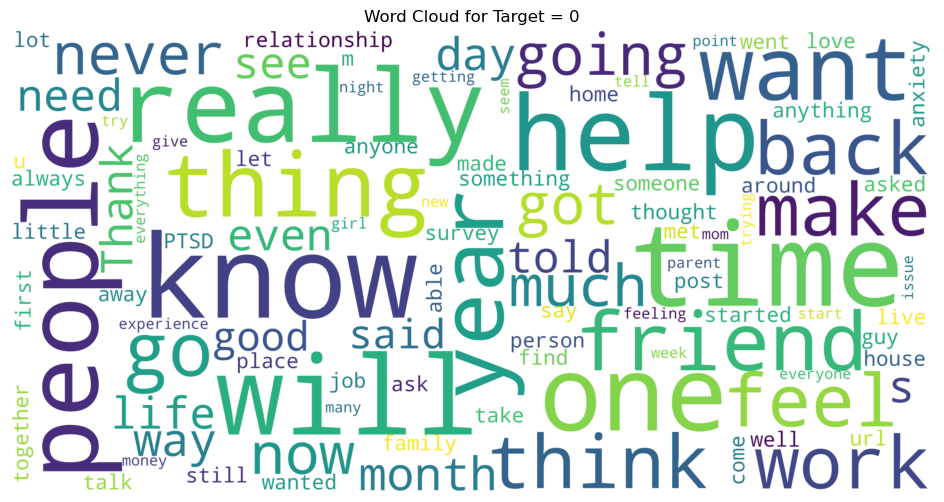

In [14]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Filtrar el DataFrame en función del valor de 'target'
text_target_0 = ' '.join(df[df['label'] == 0]['text'])

# Verificar longitud del texto para target = 1
print(f"Length of text for target = 0: {len(text_target_1)}")

# Crear la nube de palabras para target = 1
wordcloud_1 = WordCloud(
    max_font_size=100,
    max_words=100,
    background_color="white",
    scale=10,
    width=800,
    height=400
).generate(text_target_0)

# Configurar y mostrar la nube de palabras
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud_1, interpolation="bilinear")
plt.axis("off")
plt.title('Word Cloud for Target = 0')
plt.show()

Vemos que la palabra "friend" y "know" tambien son muy recurrentes en personas que no se encuentran estresadas.

# Procesamiento con NLTK

### Conversión de palabras a letras minúsculas

In [15]:
df['text_new'] = df['text'].apply(lambda x: x.lower())

### Eliminación de caracteres especiales

Remuevo los caracteres especiales

In [16]:
from nltk import word_tokenize
import nltk

nltk.download('punkt')

token_lists = [word_tokenize(each) for each in df['text']] #se convierte cada texto en una lista de palabras
tokens = [item for sublist in token_lists for item in sublist] #es una lista, donde cada sublista tiene los tokens de un post
print("Numero de tokens unicos antes: ", len(set(tokens))) #se eliminan duplicados con set

token_lists_lower = [word_tokenize(each) for each in df['text_new']] # se tokeniza de la misma forma la columna de text_new que tiene los posts en minusculas
tokens_lower = [item for sublist in token_lists_lower for item in sublist]
print("Numero de tokens unicos nuevos: ", len(set(tokens_lower)))

[nltk_data] Downloading package punkt to C:\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Numero de tokens unicos antes:  13888
Numero de tokens unicos nuevos:  12442


In [17]:
(12442 - 13888) / 13888

-0.10411866359447004

Se observa que el número de tokens bajó cerca del 18% con la normalización

In [18]:
# se seleccionan los caracteres no alfa numericos que no son espacios
special_chars = df['text_new'].apply(lambda x: [each for each in list(x) if not each.isalnum() and each != ' '])

# se obtiene una lista de listas
flat_list = [item for sublist in special_chars for item in sublist]

# caracteres especiales unicos
print(set(flat_list))

{'😔', '¯', '👩', '💕', ':', '”', '●', '➡', ']', '\u200d', '€', '🎓', '#', '@', '💸', '*', '=', '~', '️', '—', '’', '“', '?', ',', '>', '%', '·', '\\', '!', '😇', '+', '–', "'", '-', '🐰', ')', '‘', '😦', '(', '_', '.', '•', '^', '$', '…', '\u200e', '"', '<', '&', '🙂', '/', '£', ';', '❤', '🥕', '[', '\t', '´'}


Eliminación de caracteres especiales

In [19]:
import re
review_backup = df['text_new'].copy()
df['text_new'] = df['text_new'].apply(
    lambda x: re.sub('[^A-Za-z0-9 ]+', ' ', x)
)

Visualización de resultados al eliminar caracteres especiales

In [20]:
print("Review anterior:")
review_backup.values[0]

Review anterior:


'he said he had not felt that way before, suggeted i go rest and so ..trigger ahead if youi\'re a hypocondriac like me: i decide to look up "feelings of doom" in hopes of maybe getting sucked into some rabbit hole of ludicrous conspiracy, a stupid "are you psychic" test or new age b.s., something i could even laugh at down the road. no, i ended up reading that this sense of doom can be indicative of various health ailments; one of which i am prone to.. so on top of my "doom" to my gloom..i am now f\'n worried about my heart. i do happen to have a physical in 48 hours.'

In [21]:
print("Review nuevo:")
df['text_new'][0]

Review nuevo:


'he said he had not felt that way before  suggeted i go rest and so  trigger ahead if youi re a hypocondriac like me  i decide to look up  feelings of doom  in hopes of maybe getting sucked into some rabbit hole of ludicrous conspiracy  a stupid  are you psychic  test or new age b s  something i could even laugh at down the road  no  i ended up reading that this sense of doom can be indicative of various health ailments  one of which i am prone to  so on top of my  doom  to my gloom i am now f n worried about my heart  i do happen to have a physical in 48 hours '

Número de tokens eliminados

In [22]:
token_lists = [word_tokenize(each) for each in df['text']]
tokens = [item for sublist in token_lists for item in sublist]
print("Numero de token unicos antes: ", len(set(tokens)))

token_lists = [word_tokenize(each) for each in df['text_new']]
tokens = [item for sublist in token_lists for item in sublist]
print("Numero de tokens unicos despues: ", len(set(tokens)))

Numero de token unicos antes:  13888
Numero de tokens unicos despues:  11529


# Eliminación de stopwords y palabras de alta frecuencia

### StopWords

In [23]:
import nltk
nltk.download('stopwords')

noise_words = []
stopwords_corpus = nltk.corpus.stopwords
eng_stop_words = stopwords_corpus.words('english')
noise_words.extend(eng_stop_words)
print(len(noise_words))
noise_words

179


[nltk_data] Downloading package stopwords to C:\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

### Palabras de alta y baja frecuencia

 (1% de las palabras que aparecen con más frecuencia)

- Palabras de alta frecuencia

In [24]:
one_percentile = int(len(set(tokens)) * 0.01) #calcula el 1% de los tokens
top_1_percentile = Counter(tokens).most_common(one_percentile) #busca el 1% mas comun 
top_1_percentile[:10]

[('i', 13907),
 ('to', 8315),
 ('and', 7954),
 ('the', 6236),
 ('a', 5339),
 ('my', 4471),
 ('of', 3634),
 ('it', 3521),
 ('that', 3038),
 ('me', 3036)]

Text(0, 0.5, 'Frecuencia')

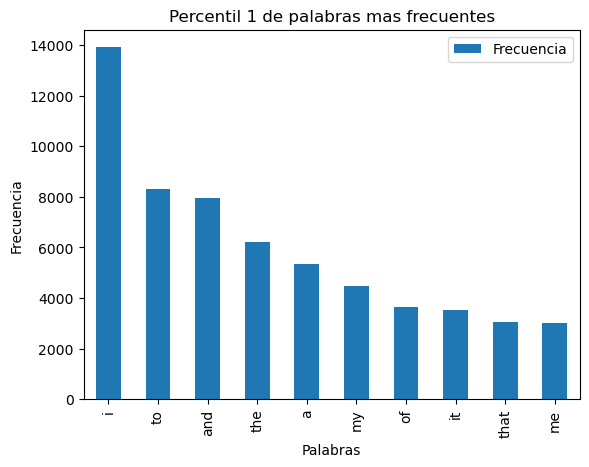

In [25]:
pd.DataFrame(top_1_percentile[:10], columns=['Palabras','Frecuencia']).set_index('Palabras').plot(kind='bar')
plt.title('Percentil 1 de palabras mas frecuentes')
plt.xlabel('Palabras')
plt.ylabel('Frecuencia')

- Palabras de baja frecuencia

In [26]:
bottom_1_percentile = Counter(tokens).most_common()[-one_percentile:]
bottom_1_percentile[:10]

[('labyrinth', 1),
 ('bureaucracy', 1),
 ('squeeze', 1),
 ('wayne', 1),
 ('guzzler', 1),
 ('lightheadedness', 1),
 ('extremities', 1),
 ('radiates', 1),
 ('disassociation', 1),
 ('usd', 1)]

Se agregan las palabras de alta y baja frecuencia a la lista de las noise_words donde estaban las stop-words

In [27]:
noise_words.extend([word for word,val in top_1_percentile])
noise_words.extend([word for word,val in bottom_1_percentile])

# Stemming y Lemantizacion - esto esta medio al pedo

In [28]:
from nltk.stem import PorterStemmer, WordNetLemmatizer, LancasterStemmer

nltk.download('wordnet')

from nltk.corpus import wordnet

porter = PorterStemmer()
lancaster = LancasterStemmer()
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to C:\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


- Los algoritmos de stemming cortan al principio o al final de cada palabra, teniendo en cuenta una lista de sufijos y prefijos
- Los algoritmos de lematización tienen en cuenta la gramática de la palabra, encontrando la palabra raiz

In [29]:
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to C:\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

Ejemplo

In [30]:
print("Lancaster Stemmer")
print(lancaster.stem("trouble"))
print(lancaster.stem("troubling"))
print(lancaster.stem("troubled"))

# Proveer una palabra que sera lemantizada
print("WordNet Lemmatizer")
print(lemmatizer.lemmatize("trouble", wordnet.NOUN))
print(lemmatizer.lemmatize("troubling", wordnet.VERB))
print(lemmatizer.lemmatize("troubled", wordnet.VERB))

Lancaster Stemmer
troubl
troubl
troubl
WordNet Lemmatizer
trouble
trouble
trouble


# Creacion y modelo de ML

desp veo que pongo aca

# Vectorizacion (BOW)

Se tokenizan las noise words para evitar warnings y separar contracciones o frases en las stopwords

In [31]:
processed_stopwords = [word.lower() for stopword in noise_words for word in word_tokenize(stopword)]


### BOLSA DE PALABRAS - BAG OF WORDS

In [32]:
# Creacion de un objeto tipo CountVectorizer
bow_counts = CountVectorizer(
    tokenizer=word_tokenize, #tokenizador de nltk
    stop_words=processed_stopwords, #eliminamos stopwords y palabras de alta y baja frecuencia
    ngram_range=(1, 2) #bigramas
)

Dividimos en datos de entrenamiento y de prueba. Hacerlo antes de vectorizar sirve para poder compararlas mas facilmente con los textos originales, antes de que hayan sido preprocesadas y vectorizadas

In [33]:
train, test = train_test_split(df, test_size=0.2, random_state=0)

In [34]:
X_train_bow = bow_counts.fit_transform(train['text_new']) #fit_transform para vectorizar conjutno de entrenamiento
X_test_bow = bow_counts.transform(test['text_new']) #transform vectorizar conjunto de prueba

c:\Users\VICTUS\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [35]:
len(bow_counts.get_feature_names_out()) + 1

73875

In [36]:
y_train_bow = train['label']
y_test_bow = test['label']

In [37]:
y_test_bow.value_counts() / y_test_bow.shape[0]

1    0.519366
0    0.480634
Name: label, dtype: float64

--------------------------------------------------

# Modelo de Regresión Logistica

In [38]:
# modelo y entrenamiento
model = LogisticRegression(C=0.9, solver="liblinear") #defino el modelo
model.fit(X_train_bow, y_train_bow) #entrenamiento

# prediccion
test_pred_lr_prob = model.predict_proba(X_test_bow) #
test_pred_lr_all = model.predict(X_test_bow)


In [39]:

print("F1 score: ", f1_score(y_test_bow, test_pred_lr_all))
print("Accuracy: ", accuracy_score(y_test_bow, test_pred_lr_all) * 100)

F1 score:  0.7551020408163265
Accuracy:  74.64788732394366


### Validacion cruzada

In [40]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Definir StratifiedKFold
skf = StratifiedKFold(n_splits=10, random_state=0, shuffle=True)

y_train_bow_array = np.array(y_train_bow)

# Creación de listas para almacenar las métricas
accuracies = []
precisions = []
recalls = []
f1s = []

# Iterar sobre los splits de StratifiedKFold
for train_index, test_index in skf.split(X_train_bow, y_train_bow_array):
    # Usar los índices directamente sin iloc
    X_train_vc, X_test_vc = X_train_bow[train_index], X_train_bow[test_index]
    y_train_vc, y_test_vc = y_train_bow_array[train_index], y_train_bow_array[test_index]

    # Entrenar el modelo
    model.fit(X_train_vc, y_train_vc)

    # Predicciones en el conjunto de prueba
    pred = model.predict(X_test_vc)

    # Calcular las métricas
    accuracies.append(accuracy_score(y_test_vc, pred))
    precisions.append(precision_score(y_test_vc, pred, average='weighted'))
    recalls.append(recall_score(y_test_vc, pred, average='weighted'))
    f1s.append(f1_score(y_test_vc, pred, average='weighted'))

# Métricas promedio
print(f"Accuracy promedio (StratifiedKFold): {np.mean(accuracies):.2f}")
print(f"Precision promedio (StratifiedKFold): {np.mean(precisions):.2f}")
print(f"Recall promedio (StratifiedKFold): {np.mean(recalls):.2f}")
print(f"F1 Score promedio (StratifiedKFold): {np.mean(f1s):.2f}")


Accuracy promedio (StratifiedKFold): 0.71
Precision promedio (StratifiedKFold): 0.71
Recall promedio (StratifiedKFold): 0.71
F1 Score promedio (StratifiedKFold): 0.71


### Ajuste de hiperparametros

In [41]:
from sklearn.model_selection import ParameterGrid


In [43]:
params_grid = {
    'C': [1, 10, 100],  
    'solver': ['lbfgs', 'saga'],
    'max_iter': [100, 500, 1000, 2000, 5000]  
    
}



from sklearn.model_selection import HalvingGridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay


halving_cv = HalvingGridSearchCV(model, params_grid, scoring="accuracy", factor=3)
halving_cv.fit(X_train_bow, y_train_bow)

# Mejores parámetros y el mejor score de validación cruzada
print("Mejores parámetros:", halving_cv.best_params_)
print("Mejor Score CV:", halving_cv.best_score_)

# Rendimiento del modelo en el conjunto de prueba
y_test_pred = halving_cv.predict(X_test_bow)
accuracy_RL = accuracy_score(y_test_bow, y_test_pred)
precision_RL = precision_score(y_test_bow, y_test_pred, average='weighted')
recall_RL = recall_score(y_test_bow, y_test_pred, average='weighted')
f1_RL = f1_score(y_test_bow, y_test_pred, average='weighted')

# Métricas
print(f'Accuracy del modelo = {round(accuracy_RL, 5)}')
print(f'Precision del modelo = {round(precision_RL, 5)}')
print(f'Recall del modelo = {round(recall_RL, 5)}')
print(f'F1 Score del modelo = {round(f1_RL, 5)}')



c:\Users\VICTUS\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\VICTUS\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\VICTUS\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\VICTUS\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\VICTUS\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\VICTUS\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max

Mejores parámetros: {'C': 100, 'max_iter': 1000, 'solver': 'lbfgs'}
Mejor Score CV: 0.7099337748344372
Accuracy del modelo = 0.75
Precision del modelo = 0.75
Recall del modelo = 0.75
F1 Score del modelo = 0.75


### Frecuencias

In [36]:
feature_names = np.array(bow_counts.get_feature_names_out())
sorted_coef_index = model.coef_[0].argsort()
print('Coefs Stressed : \n{}'.format(feature_names[sorted_coef_index[:-21:-1]]))
print()
print('Coefs Not stressed :\n{}\n'.format(feature_names[sorted_coef_index[:20]]))

Coefs Stressed : 
['hate' 'scared' 'anxious' 'stop' 'sick' 'tell' 'safe' 'fucking' 'days'
 'boyfriend' 'afraid' 'horrible' 'mentally' 'terrified' 'trying' 'crying'
 'literally' 'leave' 'hard' 'sorry']

Coefs Not stressed :
['met' 'thank' 'older' '1' 'great' 'first' 'free' 'value' 'let' 'nice'
 'experience' 'helped' 'finally' 'way' 'loving' '>' 'turned' 'world' 'bit'
 'may']



### Wordclouds

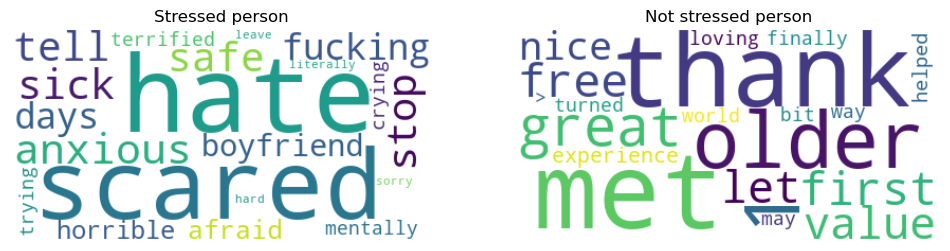

In [37]:
import numpy as np
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# palabras y coeficientes
feature_names = np.array(bow_counts.get_feature_names_out())
sorted_coef_index = model.coef_[0].argsort()

# Palabras con coeficientes altos
top_words = feature_names[sorted_coef_index[:-40:-1]]
top_freqs = np.abs(model.coef_[0][sorted_coef_index[:-40:-1]])

# Palabras con coeficientes bajos
bottom_words = feature_names[sorted_coef_index[:40]]
bottom_freqs = np.abs(model.coef_[0][sorted_coef_index[:40]])

# Crear diccionarios de frecuencias para WordCloud
top_word_freq = dict(zip(top_words, top_freqs))
bottom_word_freq = dict(zip(bottom_words, bottom_freqs))

# Generar y mostrar las WordClouds
plt.figure(figsize=(12, 6))

# Top coefficients
plt.subplot(1, 2, 1)
plt.imshow(WordCloud(max_font_size=100, max_words=20, background_color="white").generate_from_frequencies(top_word_freq), interpolation="bilinear")
plt.axis("off")
plt.title("Stressed person")

# Bottom coefficients
plt.subplot(1, 2, 2)
plt.imshow(WordCloud(max_font_size=100, max_words=20, background_color="white").generate_from_frequencies(bottom_word_freq), interpolation="bilinear")
plt.axis("off")
plt.title("Not stressed person")

plt.show()


# XGBoost

In [55]:
clf_xgb = xgb.XGBClassifier(objective='binary:logistic', n_estimators=10,seed=42,max_depth=6, learning_rate=0.01)
clf_xgb.fit(X_train_bow,y_train_bow) #Entrenamos el modelo


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=10, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [56]:
y_train_pred = clf_xgb.predict(X_train_bow) #Prediccion en Train
y_test_pred = clf_xgb.predict(X_test_bow) #Prediccion en Test

In [57]:
accuracy_XGB = accuracy_score(y_test_bow, y_test_pred)
precision_XGB = precision_score(y_test_bow, y_test_pred, average='weighted')
recall_XGB = recall_score(y_test_bow, y_test_pred, average='weighted')
f1_XGB = f1_score(y_test_bow, y_test_pred, average='weighted')

print(f'Precisión: {precision_XGB:.2f}')
print(f'Accuracy: {accuracy_XGB:.2f}')
print(f'Recall: {recall_XGB:.2f}')
print(f'F1 Score: {f1_XGB:.2f}')

Precisión: 0.63
Accuracy: 0.57
Recall: 0.57
F1 Score: 0.48


# Red Neuronal 

In [43]:
import tensorflow as tf

In [44]:
X_train_bow.shape

(2270, 73874)

In [55]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense



In [59]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(X_train_bow.shape[1],)))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


c:\Users\VICTUS\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [60]:
history = model.fit(
    X_train_bow,    # Datos de entrenamiento
    y_train_bow,        # Etiquetas de entrenamiento
    epochs=10,      # Número de épocas (ajusta según sea necesario)
    batch_size=32,  # Tamaño del lote (ajusta según sea necesario)
    validation_split=0.2,  # Usa un 20% de los datos para validación
    verbose=1       # Para mostrar el progreso en la consola
)

Epoch 1/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - accuracy: 0.5311 - loss: 0.6853 - val_accuracy: 0.7357 - val_loss: 0.6063
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.8704 - loss: 0.4033 - val_accuracy: 0.7401 - val_loss: 0.5695
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.9807 - loss: 0.0734 - val_accuracy: 0.7269 - val_loss: 0.6471
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.9963 - loss: 0.0170 - val_accuracy: 0.7269 - val_loss: 0.7075
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.9972 - loss: 0.0097 - val_accuracy: 0.7313 - val_loss: 0.7258
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.9984 - loss: 0.0066 - val_accuracy: 0.7247 - val_loss: 0.7563
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.9982 - loss: 0.0060 - val_accuracy: 0.7269 - val_loss: 0.7617
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.9998 - loss: 0.0020 - val_accuracy: 0.7269 - v

In [61]:
test_loss, test_acc = model.evaluate(X_test_bow, y_test_bow)
print(f"Test Accuracy: {test_acc}")


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7165 - loss: 0.8264
Test Accuracy: 0.7235915660858154


In [62]:
predictions = model.predict(X_test_bow)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


# Modelo LSTM

### Eliminacion de stopwords


In [73]:
def remove_noise(text, noisewords):
    tokens = word_tokenize(text.lower())
    cleaned_text = [word for word in tokens if word not in noisewords]
    return ' '.join(cleaned_text)

X_train_clean = train['text_new'].apply(lambda x: remove_noise(x, noise_words))
X_test_clean = test['text_new'].apply(lambda x: remove_noise(x, noise_words))


In [74]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X_train_clean)

# Convertimos los textos a secuencias
train_sequences = tokenizer.texts_to_sequences(X_train_clean)
test_sequences = tokenizer.texts_to_sequences(X_test_clean)

# Padding para tener secuencias de la misma longitud
X_train_padded = pad_sequences(train_sequences, maxlen=100)
X_test_padded = pad_sequences(test_sequences, maxlen=100)


In [99]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense

model = Sequential()
model.add(Embedding(input_dim=10000, output_dim=256, input_length=100))
model.add(LSTM(units=256, return_sequences=False))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Entrenamiento
model.fit(X_train_padded, y_train_bow, epochs=10, batch_size=32, validation_data=(X_test_padded, y_test_bow))


Epoch 1/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 10s 115ms/step - accuracy: 0.5627 - loss: 0.6856 - val_accuracy: 0.7465 - val_loss: 0.5353
Epoch 2/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 8s 111ms/step - accuracy: 0.8660 - loss: 0.3342 - val_accuracy: 0.7218 - val_loss: 0.5573
Epoch 3/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 8s 112ms/step - accuracy: 0.9608 - loss: 0.1255 - val_accuracy: 0.6989 - val_loss: 0.7772
Epoch 4/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 8s 111ms/step - accuracy: 0.9934 - loss: 0.0317 - val_accuracy: 0.7236 - val_loss: 0.9621
Epoch 5/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 8s 111ms/step - accuracy: 0.9992 - loss: 0.0080 - val_accuracy: 0.6989 - val_loss: 1.1037
Epoch 6/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 8s 112ms/step - accuracy: 0.9914 - loss: 0.0316 - val_accuracy: 0.6954 - val_loss: 1.1643
Epoch 7/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 8s 111ms/step - accuracy: 0.9974 - loss: 0.0136 - val_accuracy: 0.7042 - val_loss: 1.0866
Epoch 8/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 8s 113ms/step - accuracy: 0.9979 - loss: 0.0071 - val_accuracy: 0

In [100]:
# Evaluación en el conjunto de prueba
loss, accuracy = model.evaluate(X_test_padded, y_test_bow)

print(f'Pérdida en el conjunto de prueba: {loss}')
print(f'Precisión en el conjunto de prueba: {accuracy}')


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.7219 - loss: 1.3969
Pérdida en el conjunto de prueba: 1.3775521516799927
Precisión en el conjunto de prueba: 0.7253521084785461


In [79]:
# Ver la distribución de clases en el conjunto de entrenamiento
print(y_train_bow.value_counts())

# Ver la distribución de clases en el conjunto de prueba
print(y_test_bow.value_counts())


1    1193
0    1077
Name: label, dtype: int64
1    295
0    273
Name: label, dtype: int64
